In [1]:
pip install torch transformers regex safetensors gcsfs

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers torch scikit-learn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
!nvidia-smi

Sat Aug 19 07:05:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      0MiB / 15360MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
from transformers import get_linear_schedule_with_warmup, BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import torch.optim as optim
import torch.nn as nn
import os
import numpy as np
import time
import pandas as pd
import numpy as np

In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
import pandas as pd

# Define the path to the CSV file in GCS
csv_path = "gs://vino-verdict/data/wine_3scale.csv"

# Read the CSV using pandas
df = pd.read_csv(csv_path)

In [7]:
df.head()

,country,description,points,price,province,region_1,title,variety,winery,year,verdict
0,US,"Good acidity on this clean, vibrant wine, with...",87,20.000000,California,Santa Ynez Valley,Tercero 2009 Camp 4 Grenache Blanc (Santa Ynez...,Grenache Blanc,Tercero,2009,bad
1,US,Soft on the palate and built on a foundation o...,85,51.571429,California,Calistoga,Sterling 2012 Cellar Club Cabernet Sauvignon (...,Cabernet Sauvignon,Sterling,2012,bad
2,US,Sweetly extracted fruit and oak star in this r...,88,50.000000,California,Los Carneros,Talisman 2009 Adastra Vineyard Pinot Noir (Los...,Pinot Noir,Talisman,2009,bad
3,Chile,The bouquet is fairly exotic as it kicks up so...,85,17.000000,Central Valley,NaN,Valdivieso 2000 Single Vineyard Reserve Merlot...,Merlot,Valdivieso,2000,bad
4,US,A simple Pinot Noir that was a little sweet an...,82,40.000000,California,Russian River Valley,B.R. Cohn 2009 Pinot Noir (Russian River Valley),Pinot Noir,B.R. Cohn,2009,bad


In [8]:
# 1. Preprocess the `description` column

# Check for missing values in the description and verdict columns
missing_values = df[['description', 'verdict']].isnull().sum()

# Drop rows with missing descriptions (if any)
df = df.dropna(subset=['description'])

# Display missing values and the head of the DataFrame
missing_values, df[['description', 'verdict']].head()

(description    0
 verdict        0
 dtype: int64,
                                          description verdict
 0  Good acidity on this clean, vibrant wine, with...     bad
 1  Soft on the palate and built on a foundation o...     bad
 2  Sweetly extracted fruit and oak star in this r...     bad
 3  The bouquet is fairly exotic as it kicks up so...     bad
 4  A simple Pinot Noir that was a little sweet an...     bad)

In [9]:
df['verdict'].value_counts()

bad          5868
average      5868
excellent    5868
Name: verdict, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

# Splitting the dataframe
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['verdict'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['verdict'], random_state=42)

In [11]:
train_df.shape, valid_df.shape, test_df.shape

((14083, 11), (1760, 11), (1761, 11))

In [12]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Tokenize the descriptions from the train, validation, and test sets
train_encodings = tokenizer(list(train_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(valid_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')

train_encodings.keys()  # Display the keys to check the tokenization results

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
# Convert 'bad', 'average', and 'excellent' to 0, 1, and 2, respectively
train_labels = train_df['verdict'].replace({'bad': 0, 'average': 1, 'excellent': 2}).to_numpy()
val_labels = valid_df['verdict'].replace({'bad': 0, 'average': 1, 'excellent': 2}).to_numpy()
test_labels = test_df['verdict'].replace({'bad': 0, 'average': 1, 'excellent': 2}).to_numpy()

# Convert to PyTorch tensors
train_labels = torch.tensor(train_labels).long()
val_labels = torch.tensor(val_labels).long()
test_labels = torch.tensor(test_labels).long()

# Create datasets
train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [14]:
!nvidia-smi

Sat Aug 19 07:06:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |      0MiB / 15360MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Training hyperparameters and initialization
batch_size = 32
epochs = 5
patience = 2

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Early stopping and model saving initializations
best_val_loss = float('inf')
no_improve_epochs = 0
path_to_save = "gs://vino-verdict/models/updated_3_case_02-weight-decay.bin"

In [17]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-uncased', 
    num_labels=3,
    hidden_dropout_prob=0.3  # Dropout probability to drop out neurons, usually between 0.1 and 0.5
)
model = model.to(device)


# Loss function for binary cross entropy
# Use BCEWithLogitsLoss for binary classification with logits (includes sigmoid activation)
loss_function = nn.CrossEntropyLoss()

# Optimizer with L2 regularization
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# Look into perhaps using a Learning Rate Decay
# This starts with a higher learning rate and slowly reduces it

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

# DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [19]:
# Assuming you've already adjusted preprocessing and data loading to produce labels as 0, 1, or 2 
# corresponding to 'bad', 'average', and 'good'

# Early stopping variables
best_train_loss = float('inf')  # Initialize to a high value
no_improve_epochs = 0
patience = 3
epochs = 5
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
train_accuracies = []
gradient_accumulation_steps = 2
best_val_f1 = -float('inf')  # Initialize to a large negative value

print("Starting training...\n")

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_predictions, train_true_vals = [], []

    optimizer.zero_grad()

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        loss = loss_function(outputs.logits, labels)  # Ensure this is categorical cross-entropy
        total_train_loss += loss.item()

        # Gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Get predictions for training data
        batch_train_predictions = torch.argmax(outputs.logits, dim=1)
        train_predictions.extend(batch_train_predictions.cpu().numpy())
        train_true_vals.extend(labels.cpu().numpy())
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            
        if step % 100 == 0:
            print(f"Epoch {epoch+1} - Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    train_accuracy = accuracy_score(train_true_vals, train_predictions)
    train_accuracies.append(train_accuracy)

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_vals = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            
            val_loss += loss_function(outputs.logits, labels).item()
            
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy())
            true_vals.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(true_vals, predictions)
    val_f1 = f1_score(true_vals, predictions, average='weighted')  # Adjusted for multiclass
    
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    print(f"\nEpoch {epoch+1}/{epochs} Summary:")
    print(f"Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation F1: {val_f1:.4f}\n")

    # Check for overfitting
    if avg_train_loss < best_train_loss or abs(avg_train_loss - best_train_loss) < 0.001:  # Small threshold
        best_train_loss = avg_train_loss
        if avg_val_loss > best_val_loss:
            no_improve_epochs += 1
        else:
            no_improve_epochs = 0
            best_val_loss = avg_val_loss
    else:
        no_improve_epochs = 0

    if no_improve_epochs == patience:
        print(f"Early stopping triggered after {epoch + 1} epochs due to overfitting!")
        break
    
    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        print("Saving the best model...\n")

        temp_model_path = "./updated_3_case_02-weight-decay.bin"
        temp_config_path = "./updated_3_case_02-weight-decay.json"

        torch.save(model.state_dict(), temp_model_path)
        os.system(f"gsutil cp {temp_model_path} {path_to_save}")

        model.config.to_json_file(temp_config_path)
        os.system(f"gsutil cp {temp_config_path} gs://vino-verdict/models/")

print("Training completed.")

Starting training...

Epoch 1 - Step 0/441 - Loss: 0.3623
Epoch 1 - Step 100/441 - Loss: 0.2615
Epoch 1 - Step 200/441 - Loss: 0.2676
Epoch 1 - Step 300/441 - Loss: 0.3600
Epoch 1 - Step 400/441 - Loss: 0.3309

Epoch 1/5 Summary:
Training Loss: 0.6315 - Training Accuracy: 0.7120
Validation Loss: 0.6225 - Validation Accuracy: 0.7250 - Validation F1: 0.7254

Saving the best model...



Copying file://./updated_3_case_02-weight-decay.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][638.5 MiB/638.5 MiB]   23.2 MiB/s                                   
Operation completed over 1 objects/638.5 MiB.                                    
Copying file://./updated_3_case_02-weight-decay.json [Co

Epoch 2 - Step 0/441 - Loss: 0.3670
Epoch 2 - Step 100/441 - Loss: 0.3563
Epoch 2 - Step 200/441 - Loss: 0.3516
Epoch 2 - Step 300/441 - Loss: 0.2473
Epoch 2 - Step 400/441 - Loss: 0.2543

Epoch 2/5 Summary:
Training Loss: 0.5905 - Training Accuracy: 0.7348
Validation Loss: 0.6378 - Validation Accuracy: 0.7227 - Validation F1: 0.7172

Epoch 3 - Step 0/441 - Loss: 0.4621
Epoch 3 - Step 100/441 - Loss: 0.2171
Epoch 3 - Step 200/441 - Loss: 0.1994
Epoch 3 - Step 300/441 - Loss: 0.1819
Epoch 3 - Step 400/441 - Loss: 0.2370

Epoch 3/5 Summary:
Training Loss: 0.5705 - Training Accuracy: 0.7481
Validation Loss: 0.6305 - Validation Accuracy: 0.7256 - Validation F1: 0.7222

Epoch 4 - Step 0/441 - Loss: 0.2119
Epoch 4 - Step 100/441 - Loss: 0.2961
Epoch 4 - Step 200/441 - Loss: 0.3148
Epoch 4 - Step 300/441 - Loss: 0.3517
Epoch 4 - Step 400/441 - Loss: 0.2956

Epoch 4/5 Summary:
Training Loss: 0.5569 - Training Accuracy: 0.7481
Validation Loss: 0.6355 - Validation Accuracy: 0.7222 - Validation F

In [20]:
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()
test_predictions, test_true_vals = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Get class predictions
        batch_predictions = torch.argmax(outputs.logits, dim=1)
        test_predictions.extend(batch_predictions.cpu().numpy())
        test_true_vals.extend(labels.cpu().numpy())

In [21]:
unique_preds = set(test_predictions)
print("Unique predictions:", unique_preds)

Unique predictions: {0, 1, 2}


In [22]:
from collections import Counter
class_distribution = Counter(test_true_vals)
print("Class distribution in test data:", class_distribution)

Class distribution in test data: Counter({2: 587, 1: 587, 0: 587})


In [27]:
# Calculate metrics
accuracy = accuracy_score(test_true_vals, test_predictions)
f1 = f1_score(test_true_vals, test_predictions, average='weighted')
conf_matrix = confusion_matrix(test_true_vals, test_predictions)
class_report = classification_report(test_true_vals, test_predictions, target_names=['bad', 'average', 'excellent'])
precision = precision_score(test_true_vals, test_predictions, average='weighted')
recall = recall_score(test_true_vals, test_predictions, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:\n", class_report)

Precision: 0.7532024145887722
Recall: 0.7501419647927314
Accuracy: 0.7501419647927314
F1 Score: 0.7487682169401674

Confusion Matrix:
[[437 143   7]
 [ 69 364 154]
 [  3  64 520]]

Classification Report:
               precision    recall  f1-score   support

         bad       0.86      0.74      0.80       587
     average       0.64      0.62      0.63       587
   excellent       0.76      0.89      0.82       587

    accuracy                           0.75      1761
   macro avg       0.75      0.75      0.75      1761
weighted avg       0.75      0.75      0.75      1761



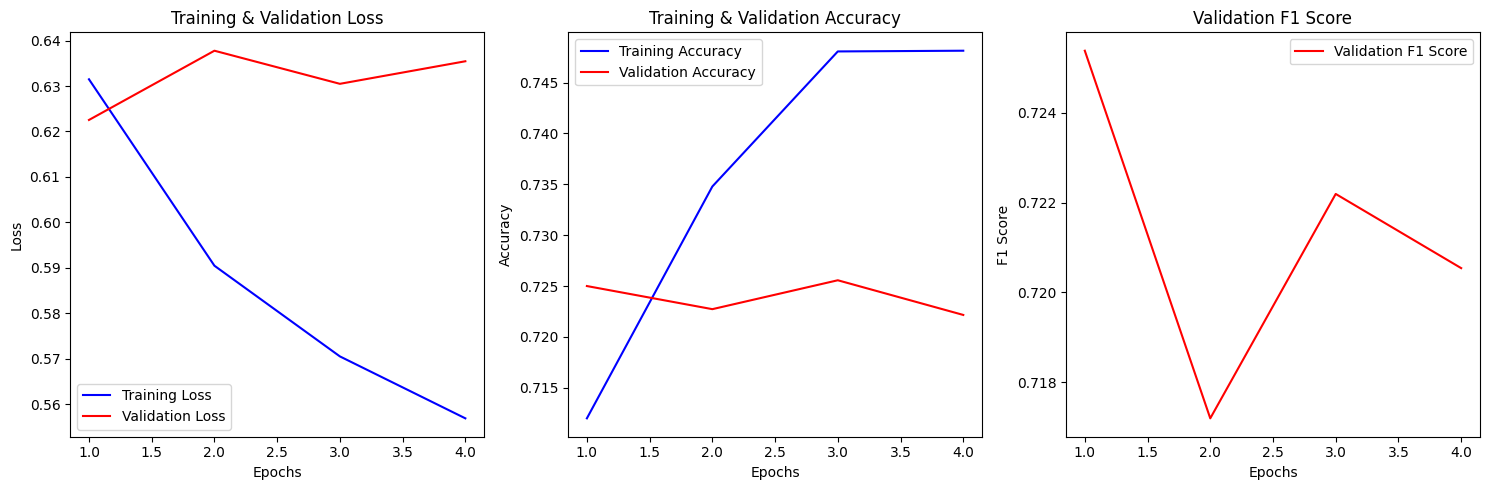

In [28]:
import matplotlib.pyplot as plt

# Your data
epochs_range = list(range(1, len(train_losses) + 1))
training_losses = train_losses
validation_accuracies = val_accuracies
validation_f1_scores = val_f1_scores
validation_losses = val_losses

# Plotting
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Training and Validation F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score', color='red')
# You can also add Training F1 Scores if you've computed them
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()